<h1 id="section3" color: #1d3557> 1. Import package </h1>

In [1]:
import requests
import pdb
import re
import os
import random
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0"}
base_url = 'https://reelgood.com/'

<h1>2. Function to Fetch URL with Retry Logic</h1>


In [3]:
def fetch_url(url, headers, max_attempts=10):
    for attempt in range(max_attempts):
        timeout = random.randint(1, 10)
        try:
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()  # Raise en exception pour les HTTP erreurs 
            print(f'Successfully fetched {url}')
            return response
        except requests.RequestException as e:
            print(f'Attempt {attempt + 1} failed for {url} with timeout {timeout}: {e}')
    return None

<h1>3. Fetch Base URL and Find Category URLs</h1>

In [4]:
response = fetch_url(base_url, headers)
if response:
    contenu = response.text
    pattern_categories = '<a class="css-7s3mks ewkc9rp0" aria-expanded="false" href="(.*?)">'
    categories_urls = re.findall(pattern_categories, contenu)

    for category_url in categories_urls:
        category_url_full = f"https://reelgood.com{category_url}"
        category_name = category_url.split('/')[-1]
        folder = f"Pages/{category_name}"
        os.makedirs(folder, exist_ok=True)

        category_response = fetch_url(category_url_full, headers, max_attempts=10)
        if category_response:
            category_content = category_response.text

            if category_name == 'new':
                
                subcategories = ['new', 'coming', 'leaving']
                for subcategory in subcategories:
                    subcategory_url_full = f"https://reelgood.com/{subcategory}"
                    subcategory_folder = f"{folder}/{subcategory.capitalize()}"
                    os.makedirs(subcategory_folder, exist_ok=True)

                    subcategory_response = fetch_url(subcategory_url_full, headers, max_attempts=10)
                    if subcategory_response:
                        subcategory_content = subcategory_response.text

                        # Extraire streaming sources (e.g., Netflix, Amazon) 
                        pattern_sources = r'href="/{}/(.*?)"'.format(subcategory)
                        sources = re.findall(pattern_sources, subcategory_content)

                        for source in sources:
                            source_folder = os.path.join(subcategory_folder, source.capitalize())
                            os.makedirs(source_folder, exist_ok=True)

                            source_url_full = f"https://reelgood.com/{subcategory}/{source}"
                            source_response = fetch_url(source_url_full, headers, max_attempts=10)
                            if source_response:
                                source_content = source_response.text

                                # Extraire films dans chaque subcategories 
                                pattern_links = r'"content-listing-link" href="(.*?)" class="css-0 ewkc9rp0"'
                                links = re.findall(pattern_links, source_content)

                                for link in links:
                                    link_full = f"https://reelgood.com{link}"
                                    content_response = fetch_url(link_full, headers, max_attempts=10)
                                    if content_response:
                                        content_link = content_response.text
                                        filename = os.path.join(source_folder, f"{link.split('/')[-1]}.html")
                                        with open(filename, 'w', encoding='utf8') as f:
                                            f.write(content_link)
                            renamed_folder = f"Pages/movies & tv shows"
            else:
                # Extraire les subcategories dynamiquement
                pattern_subcategories = f'href="/{category_name}/(.*?)"'
                subcategories = re.findall(pattern_subcategories, category_content)
    
                for subcategory in subcategories:
                    subcategory_folder = os.path.join(folder, subcategory.capitalize())
                    os.makedirs(subcategory_folder, exist_ok=True)

                    subcategory_url_full = f"{category_url_full}/{subcategory}"
                    subcategory_response = fetch_url(subcategory_url_full, headers, max_attempts=10)
                    if subcategory_response:
                    
                        subcategory_content = subcategory_response.text

                        ''' 
                        Extraire les liens dans chaque sous categorie par exemple le doctor-who-2005 dans sous catégorie action et aventure 
                        dans la type source dans la categorie film
                        '''
                        pattern_links = r'"content-listing-link" href="(.*?)" class="css-0 ewkc9rp0"'
                        links = re.findall(pattern_links, subcategory_content)

                        for link in links:
                            '''
                            j'ai conlure que les liens des films ou series ont /show/ ou /movies/ avant le nom 
                            et non /tv/action-and-aventure/nom_film pour ça j'ai mis link coller a  https://reelgood.com 
                            '''
                            link_full = f"https://reelgood.com{link}"
                            content_response = fetch_url(link_full, headers, max_attempts=10)
                            if content_response:
                                content_link = content_response.text
                                filename = os.path.join(subcategory_folder, f"{link.split('/')[-1]}.html")
                                with open(filename, 'w', encoding='utf8') as f:
                                    f.write(content_link)
else:
    print("Failed to fetch the base URL")

Attempt 1 failed for https://reelgood.com/ with timeout 3: HTTPSConnectionPool(host='reelgood.com', port=443): Read timed out. (read timeout=3)
Successfully fetched https://reelgood.com/
Successfully fetched https://reelgood.com/tv
Successfully fetched https://reelgood.com/tv/genre/action-and-adventure
Successfully fetched https://reelgood.com/show/fallout-2024
Successfully fetched https://reelgood.com/show/tires-2024
Successfully fetched https://reelgood.com/show/the-wingfeather-saga-2022
Successfully fetched https://reelgood.com/show/shogun
Successfully fetched https://reelgood.com/show/doctor-who-2005
Successfully fetched https://reelgood.com/show/doctor-who-2023
Successfully fetched https://reelgood.com/show/young-david-2023
Attempt 1 failed for https://reelgood.com/show/3-body-problem-2023 with timeout 1: HTTPSConnectionPool(host='reelgood.com', port=443): Read timed out.
Successfully fetched https://reelgood.com/show/3-body-problem-2023
Successfully fetched https://reelgood.com/s

<h1>4. Function to Extract Information from HTML Files python</h1>

In [5]:
def extract_info_from_html(file_path):
    with open(file_path, 'r', encoding='utf8') as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    
    # Extraire les informations avec BeautifulSoup et regex
    title = soup.find('h1', class_='css-hiz1q1 e3s42hj0').text if soup.find('h1', class_='css-hiz1q1 e3s42hj0') else None
    year = re.search(r'<div class="e1dskkhw7 css-1i5l3f2 e83cah30">((.*?))</div>', content)
    reelgood_rating = re.search(r'<div><span class="css-1ycvxny ey9061w1">(.{1,2})</span>', content)
    imdb_rating = re.search(r'</style><span class="css-1ycvxny ey9061w1">(.*?)</span>', content)
    duration = re.search(r'<span duration=".*?" class="css-1r35rcf e1dskkhw11">(.*?)</span>', content)
    genres = re.findall(r'href="/movies/genre/(.*?)"', content)
    équipages = re.findall(r'<p class="css-si6acb eytn0nr3">(.{1,20})</p></a></div><div spacing="16px" class="css-zmol8d eytn0nr5"></div>', content)
    origin = re.search(r'href="/origin/(.*?)"', content)
    availability = re.findall(r'<span title="(.*?)" class=', content)

    # Créer un dictionnaire avec les données extraites
    data = {
        'Title': title,
        'Year': year.group(1) if year else None,
        'Reelgood Rating': reelgood_rating.group(1) if reelgood_rating else None,
        'IMDB Rating': imdb_rating.group(1) if imdb_rating else None,
        'Duration': duration.group(1) if duration else None,
        'Genres': ', '.join(genres),
        'Equipages': ', '.join(équipages),
        'Origin': origin.group(1) if origin else None,
        'Availability': list(set(availability))  # Utiliser set pour supprimer les duplications
    }
    
    return data



<h1>5. Extract Data from HTML Files and Create DataFrame
</h1>

In [6]:
data_list = []
for root, dirs, files in os.walk('Pages'):
    for file in files:
        if file.endswith('.html'):
            file_path = os.path.join(root, file)
            data = extract_info_from_html(file_path)
            data_list.append(data)

df = pd.DataFrame(data_list)
df.to_csv('web_scraping.csv')

In [7]:
df

,Title,Year,Reelgood Rating,IMDB Rating,Duration,Genres,Equipages,Origin,Availability
0,Atlas,(2024),71,5.7,1h 58m,"drama, action-and-adventure","Jennifer Lopez, Benny Medina, Jeffrey Fierson,...",america,"[Netflix, Netflix with Ads]"
1,Blade Runner,(1982),93,8.1,1h 57m,"drama, action-and-adventure","Harrison Ford, Rutger Hauer, Sean Young, Edwar...",united-kingdom,"[Vudu, NowTV, Google Play, Microsoft, Sky Stor..."
2,Chasing Raine,(2024),45,3.3,1h 41m,"action-and-adventure, thriller",,america,"[Microsoft, Vudu, Apple TV, Prime Video]"
3,Chief of Station,(2024),62,4.7,1h 37m,"action-and-adventure, thriller","Aaron Eckhart, Alex Pettyfer, Olga Kurylenko, ...",america,"[Microsoft, Vudu, Apple TV, Prime Video]"
4,Civil War,(2024),85,7.4,1h 49m,"drama, action-and-adventure","Kirsten Dunst, Wagner Moura, Cailee Spaeny, Ne...",united-kingdom,"[Vudu, Microsoft, Sky Store, Apple TV, Prime V..."
...,...,...,...,...,...,...,...,...,...
12743,Scare PewDiePie,(2016 - 2017),45,3.8,None,,"Sven Holmberg, Nikki McKenzie, Kiff VandenHeuv...",america,[YouTube Premium]
12744,Sing It!,(2016 - Ongoing),29,4.3,None,,"Mark Jude Sullivan, Preston Jones, Laura Schei...",america,"[iTunes, Hoopla, YouTube Premium]"
12745,Ultimate Expedition,(2018 - Ongoing),39,7.6,None,,"Alia Shelesh, Jus Reign, Olivia Gonzales, Stev...",None,[YouTube Premium]
12746,Wayne,(2019 - 2019),86,8.3,None,,"Ciara Bravo, Dean Winters, Stephen Kearin, Jam...",america,"[Prime Video, Apple TV, Channel 4, YouTube Pre..."


<h1>6. Analyzing Missing Data
</h1>

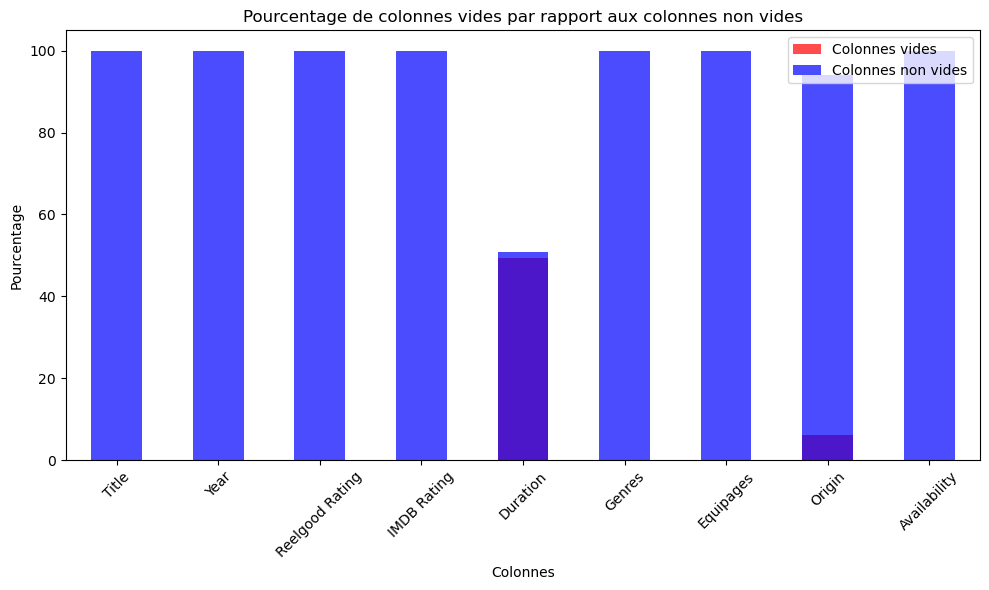

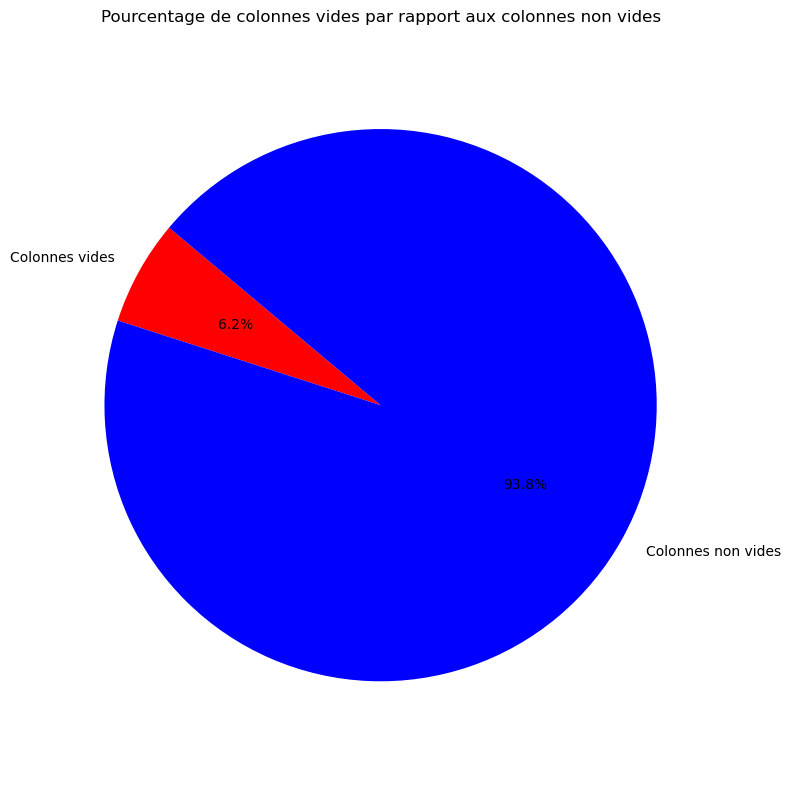

In [8]:
# Vérifier les colonnes vides
colonnes_vides = df.isna().sum()

# Calculer le pourcentage de colonnes vides par rapport aux colonnes non vides
pourcentage_colonnes_vides = (colonnes_vides / len(df)) * 100
pourcentage_colonnes_non_vides = 100 - pourcentage_colonnes_vides

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
pourcentage_colonnes_vides.plot(kind='bar', color='red', alpha=0.7, label='Colonnes vides')
pourcentage_colonnes_non_vides.plot(kind='bar', color='blue', alpha=0.7, label='Colonnes non vides')
plt.title('Pourcentage de colonnes vides par rapport aux colonnes non vides')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Créer un graphique circulaire
plt.figure(figsize=(8, 8))
plt.pie([pourcentage_colonnes_vides.sum(), pourcentage_colonnes_non_vides.sum()],
        labels=['Colonnes vides', 'Colonnes non vides'],
        colors=['red', 'blue'],
        autopct='%1.1f%%',
        startangle=140)
plt.title('Pourcentage de colonnes vides par rapport aux colonnes non vides')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [9]:
df.columns

Index(['Title', 'Year', 'Reelgood Rating', 'IMDB Rating', 'Duration', 'Genres',
       'Equipages', 'Origin', 'Availability'],
      dtype='object')

In [10]:
df.isnull().sum()

Title                 0
Year                  5
Reelgood Rating       9
IMDB Rating           0
Duration           6278
Genres                0
Equipages             0
Origin              765
Availability          0
dtype: int64

<h1>7. Data Cleaning and Analysis</h1>
<h2>7.1. Data Cleaning</h2>

In [11]:
# Filtrer le dataframe pour exclure les lignes avec des valeurs manquantes
df_clean = df.dropna()

df_clean

,Title,Year,Reelgood Rating,IMDB Rating,Duration,Genres,Equipages,Origin,Availability
0,Atlas,(2024),71,5.7,1h 58m,"drama, action-and-adventure","Jennifer Lopez, Benny Medina, Jeffrey Fierson,...",america,"[Netflix, Netflix with Ads]"
1,Blade Runner,(1982),93,8.1,1h 57m,"drama, action-and-adventure","Harrison Ford, Rutger Hauer, Sean Young, Edwar...",united-kingdom,"[Vudu, NowTV, Google Play, Microsoft, Sky Stor..."
2,Chasing Raine,(2024),45,3.3,1h 41m,"action-and-adventure, thriller",,america,"[Microsoft, Vudu, Apple TV, Prime Video]"
3,Chief of Station,(2024),62,4.7,1h 37m,"action-and-adventure, thriller","Aaron Eckhart, Alex Pettyfer, Olga Kurylenko, ...",america,"[Microsoft, Vudu, Apple TV, Prime Video]"
4,Civil War,(2024),85,7.4,1h 49m,"drama, action-and-adventure","Kirsten Dunst, Wagner Moura, Cailee Spaeny, Ne...",united-kingdom,"[Vudu, Microsoft, Sky Store, Apple TV, Prime V..."
...,...,...,...,...,...,...,...,...,...
9527,Sound of Freedom,(2023),72,7.6,2h 11m,"drama, action-and-adventure","Jim Caviezel, Mira Sorvino, Bill Camp, Gerardo...",colombia,"[Microsoft, Sky Store, Angel Studios - Guild, ..."
9561,Sound of Freedom,(2023),72,7.6,2h 11m,"drama, action-and-adventure","Jim Caviezel, Mira Sorvino, Bill Camp, Gerardo...",colombia,"[Microsoft, Sky Store, Angel Studios - Guild, ..."
9613,Sound of Freedom,(2023),72,7.6,2h 11m,"drama, action-and-adventure","Jim Caviezel, Mira Sorvino, Bill Camp, Gerardo...",colombia,"[Microsoft, Sky Store, Angel Studios - Guild, ..."
9635,Sound of Freedom,(2023),72,7.6,2h 11m,"drama, action-and-adventure","Jim Caviezel, Mira Sorvino, Bill Camp, Gerardo...",colombia,"[Microsoft, Sky Store, Angel Studios - Guild, ..."


<h2>7.2. Data Analysis and Visualization</h2>

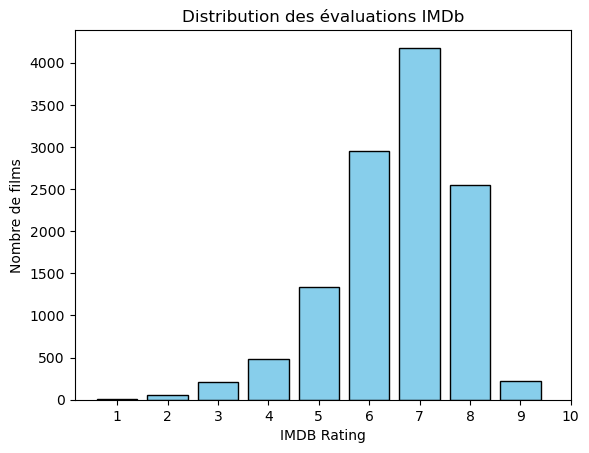

In [12]:
# Filtrer les lignes avec des valeurs non numériques dans la colonne 'IMDB Rating'
df_clean = df[pd.to_numeric(df['IMDB Rating'], errors='coerce').notna()]

# Convertir les données de la colonne 'IMDB Rating' en nombres (float)
df_clean.loc[:, 'IMDB Rating'] = df_clean['IMDB Rating'].astype(float)

# Définir les intervalles personnalisés pour l'évaluation IMDb
intervals_x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculer l'histogramme avec les intervalles personnalisés
hist, bins = np.histogram(df_clean['IMDB Rating'], bins=intervals_x)

# Tracer l'histogramme
plt.bar(bins[:-1], hist, color='skyblue', edgecolor='black')
plt.xlabel('IMDB Rating')
plt.ylabel('Nombre de films')
plt.title('Distribution des évaluations IMDb')
plt.xticks(intervals_x)  # Utiliser les intervalles comme marqueurs sur l'axe des x
plt.show()


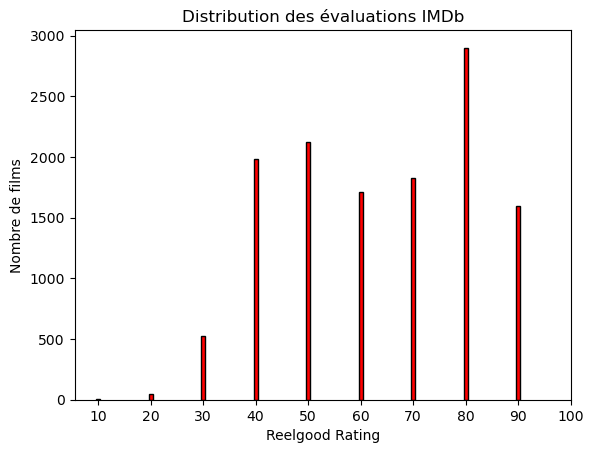

In [13]:
# Filtrer les lignes avec des valeurs non numériques dans la colonne 'Reelgood Rating'
df_clean = df[pd.to_numeric(df['Reelgood Rating'], errors='coerce').notna()]

# Convertir les données de la colonne 'Reelgood Rating' en nombres (float)
df_clean.loc[:, 'Reelgood Rating'] = df_clean['Reelgood Rating'].astype(float)

# Définir les intervalles personnalisés pour l'évaluation Reelgood
intervals_y = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Calculer l'histogramme avec les intervalles personnalisés
hist, bins = np.histogram(df_clean['Reelgood Rating'], bins=intervals_y)

# Tracer l'histogramme
plt.bar(bins[:-1], hist, color='red', edgecolor='black')
plt.xlabel('Reelgood Rating')
plt.ylabel('Nombre de films')
plt.title('Distribution des évaluations IMDb')
plt.xticks(intervals_y)  # Utiliser les intervalles comme marqueurs sur l'axe des y
plt.show()


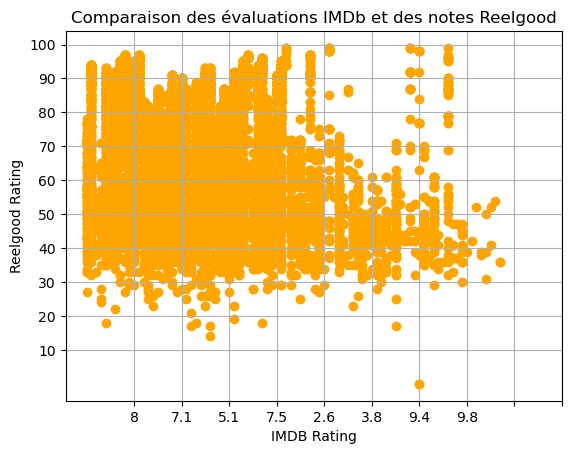

In [14]:

# Définir les intervalles personnalisés pour les axes x et y
intervals_x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
intervals_y = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Créer un nuage de points pour comparer les évaluations IMDb et les notes Reelgood
plt.scatter(df_clean['IMDB Rating'], df_clean['Reelgood Rating'], color='orange')
plt.xlabel('IMDB Rating')
plt.ylabel('Reelgood Rating')
plt.title('Comparaison des évaluations IMDb et des notes Reelgood')
plt.xticks(intervals_x)
plt.yticks(intervals_y)
plt.grid(True)
plt.show()


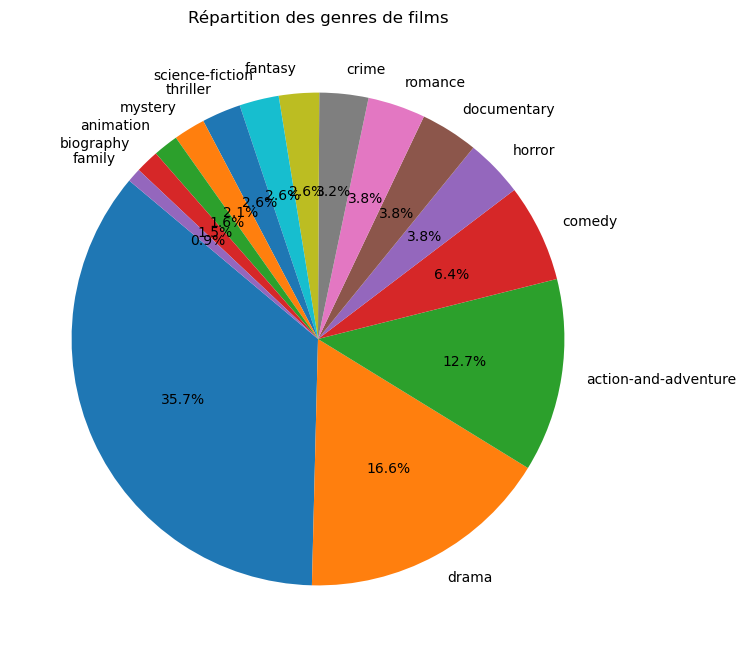

In [15]:
# Compter le nombre de films par genre
genre_counts = df_clean['Genres'].str.split(', ').explode().value_counts()
top_genres = genre_counts.head(15)

# Créer un graphique à secteurs pour visualiser la répartition des genres de films
plt.figure(figsize=(8, 8))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des genres de films')
plt.show()


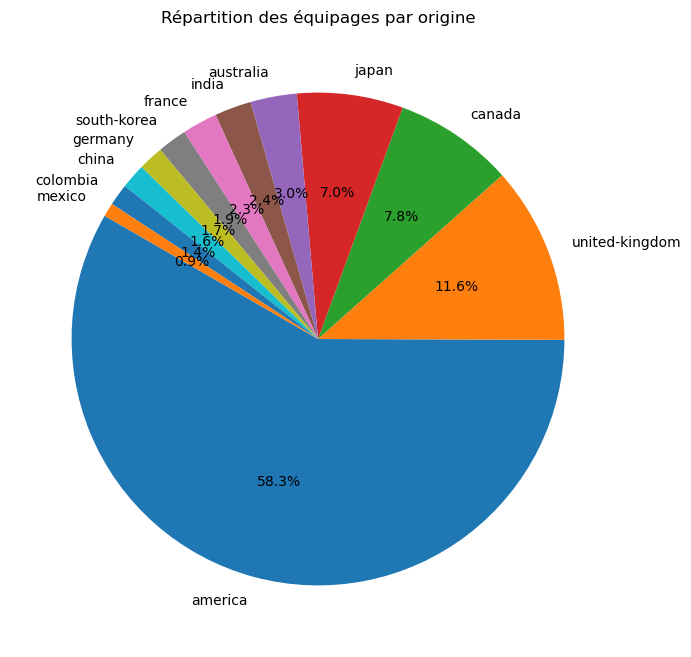

In [16]:
# Compter le nombre d'équipages par origine
origin_counts = df_clean['Origin'].value_counts()
top_origin = origin_counts.head(12)

# Créer un graphique à secteurs pour visualiser la répartition des équipages par origine
plt.figure(figsize=(8, 8))
plt.pie(top_origin, labels=top_origin.index, autopct='%1.1f%%', startangle=150)
plt.title('Répartition des équipages par origine')
plt.show()


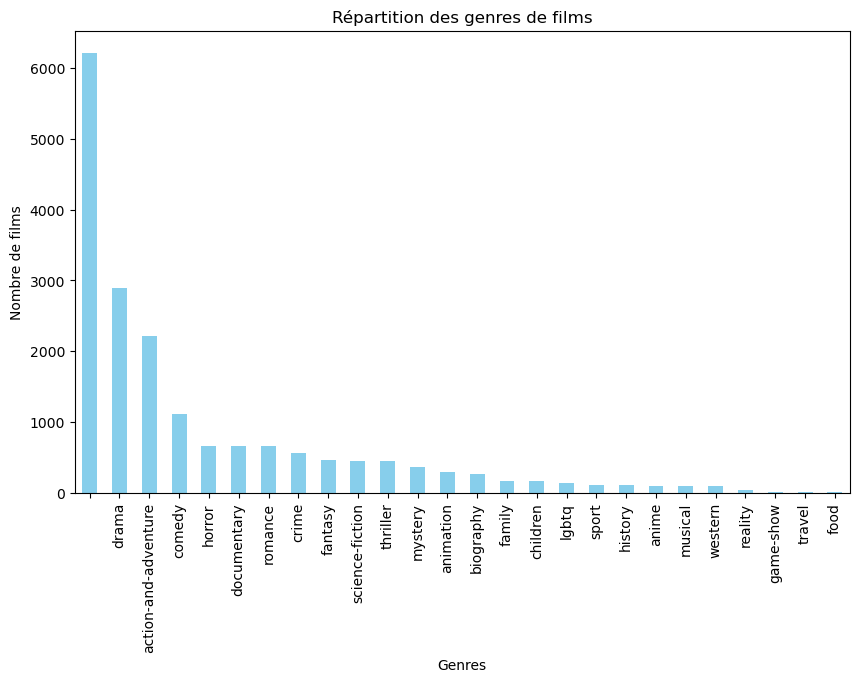

In [17]:
# Compter le nombre de films par genre
genre_counts = df_clean['Genres'].str.split(', ').explode().value_counts()

# Créer un graphique à barres empilées pour visualiser la répartition des genres de films
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Nombre de films')
plt.title('Répartition des genres de films')
plt.show()


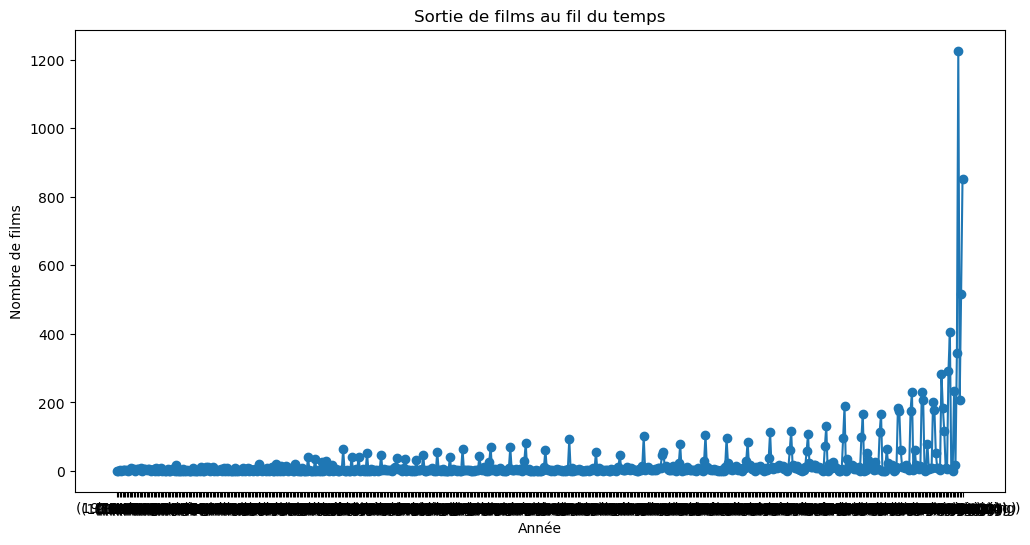

In [18]:
# Compter le nombre de films par année
year_counts = df_clean['Year'].value_counts().sort_index()

# Créer un graphique temporel
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o')
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.title('Sortie de films au fil du temps')
plt.show()


In [19]:
def convert_to_minutes(duration_str):
    """
    Convertit une durée au format "1h00m" en minutes.
    """
    if pd.isna(duration_str):
        return None  # Or any value that you want to assign for missing durations
    parts = duration_str.split('h')
    hours = int(parts[0]) if len(parts) > 1 else 0
    minutes = int(parts[-1].rstrip('m'))
    return hours * 60 + minutes

# Appliquer la fonction de conversion à la colonne 'Duration' sans déclencher de SettingWithCopyWarning
df_clean['Duration (minutes)'] = df_clean['Duration'].apply(convert_to_minutes)

# Afficher un aperçu des données
df_clean.head()


C:\Users\adem_\AppData\Local\Temp\ipykernel_16568\1078412957.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Duration (minutes)'] = df_clean['Duration'].apply(convert_to_minutes)


,Title,Year,Reelgood Rating,IMDB Rating,Duration,Genres,Equipages,Origin,Availability,Duration (minutes)
0,Atlas,(2024),71.0,5.7,1h 58m,"drama, action-and-adventure","Jennifer Lopez, Benny Medina, Jeffrey Fierson,...",america,"[Netflix, Netflix with Ads]",118.0
1,Blade Runner,(1982),93.0,8.1,1h 57m,"drama, action-and-adventure","Harrison Ford, Rutger Hauer, Sean Young, Edwar...",united-kingdom,"[Vudu, NowTV, Google Play, Microsoft, Sky Stor...",117.0
2,Chasing Raine,(2024),45.0,3.3,1h 41m,"action-and-adventure, thriller",,america,"[Microsoft, Vudu, Apple TV, Prime Video]",101.0
3,Chief of Station,(2024),62.0,4.7,1h 37m,"action-and-adventure, thriller","Aaron Eckhart, Alex Pettyfer, Olga Kurylenko, ...",america,"[Microsoft, Vudu, Apple TV, Prime Video]",97.0
4,Civil War,(2024),85.0,7.4,1h 49m,"drama, action-and-adventure","Kirsten Dunst, Wagner Moura, Cailee Spaeny, Ne...",united-kingdom,"[Vudu, Microsoft, Sky Store, Apple TV, Prime V...",109.0


In [20]:
# Define the interval size
interval_size = 15

# Create a new column for duration intervals
df_clean['Duration Interval'] = pd.cut(df_clean['Duration (minutes)'], bins=np.arange(0, df_clean['Duration (minutes)'].max() + interval_size, interval_size))

# Display a preview of the data
df_clean.head()

C:\Users\adem_\AppData\Local\Temp\ipykernel_16568\3725851485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Duration Interval'] = pd.cut(df_clean['Duration (minutes)'], bins=np.arange(0, df_clean['Duration (minutes)'].max() + interval_size, interval_size))


,Title,Year,Reelgood Rating,IMDB Rating,Duration,Genres,Equipages,Origin,Availability,Duration (minutes),Duration Interval
0,Atlas,(2024),71.0,5.7,1h 58m,"drama, action-and-adventure","Jennifer Lopez, Benny Medina, Jeffrey Fierson,...",america,"[Netflix, Netflix with Ads]",118.0,"(105.0, 120.0]"
1,Blade Runner,(1982),93.0,8.1,1h 57m,"drama, action-and-adventure","Harrison Ford, Rutger Hauer, Sean Young, Edwar...",united-kingdom,"[Vudu, NowTV, Google Play, Microsoft, Sky Stor...",117.0,"(105.0, 120.0]"
2,Chasing Raine,(2024),45.0,3.3,1h 41m,"action-and-adventure, thriller",,america,"[Microsoft, Vudu, Apple TV, Prime Video]",101.0,"(90.0, 105.0]"
3,Chief of Station,(2024),62.0,4.7,1h 37m,"action-and-adventure, thriller","Aaron Eckhart, Alex Pettyfer, Olga Kurylenko, ...",america,"[Microsoft, Vudu, Apple TV, Prime Video]",97.0,"(90.0, 105.0]"
4,Civil War,(2024),85.0,7.4,1h 49m,"drama, action-and-adventure","Kirsten Dunst, Wagner Moura, Cailee Spaeny, Ne...",united-kingdom,"[Vudu, Microsoft, Sky Store, Apple TV, Prime V...",109.0,"(105.0, 120.0]"


In [21]:
# Convert columns to numeric, coercing errors to NaN
df_clean['IMDB Rating'] = pd.to_numeric(df_clean['IMDB Rating'], errors='coerce')
df_clean['Reelgood Rating'] = pd.to_numeric(df_clean['Reelgood Rating'], errors='coerce')

# Calculer la moyenne des notes IMDb et Reelgood pour chaque intervalle
grouped = df_clean.groupby('Duration Interval').agg({
    'IMDB Rating': 'mean',
    'Reelgood Rating': 'mean'
}).reset_index()

grouped.head()

C:\Users\adem_\AppData\Local\Temp\ipykernel_16568\3747255518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['IMDB Rating'] = pd.to_numeric(df_clean['IMDB Rating'], errors='coerce')
C:\Users\adem_\AppData\Local\Temp\ipykernel_16568\3747255518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Reelgood Rating'] = pd.to_numeric(df_clean['Reelgood Rating'], errors='coerce')
C:\Users\adem_\AppData\Local\Temp\ipykernel_16568\3747255518.py:6: FutureWarning: The default of observed=False is

,Duration Interval,IMDB Rating,Reelgood Rating
0,"(0.0, 15.0]",6.679762,54.102804
1,"(15.0, 30.0]",6.990541,54.876289
2,"(30.0, 45.0]",6.540000,50.113208
3,"(45.0, 60.0]",6.510370,52.497076
4,"(60.0, 75.0]",6.081522,52.070093


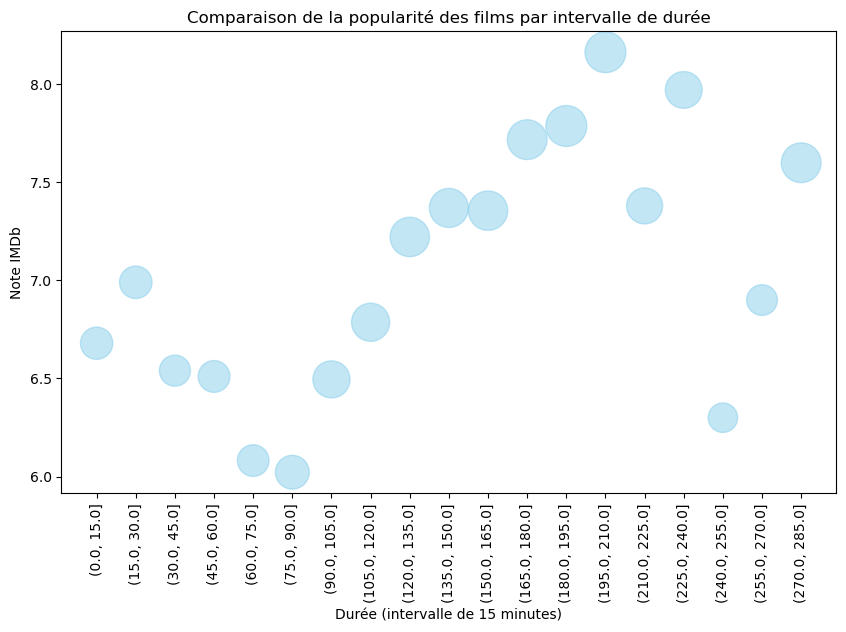

In [22]:
# Définir la taille des bulles
bubble_size = grouped['Reelgood Rating'] * 10

# Créer un diagramme à bulles
plt.figure(figsize=(10, 6))
plt.scatter(grouped['Duration Interval'].astype(str), grouped['IMDB Rating'], s=bubble_size, alpha=0.5, color='skyblue')
plt.xlabel('Durée (intervalle de 15 minutes)')
plt.ylabel('Note IMDb')
plt.title('Comparaison de la popularité des films par intervalle de durée')
plt.xticks(rotation=90)
plt.show()


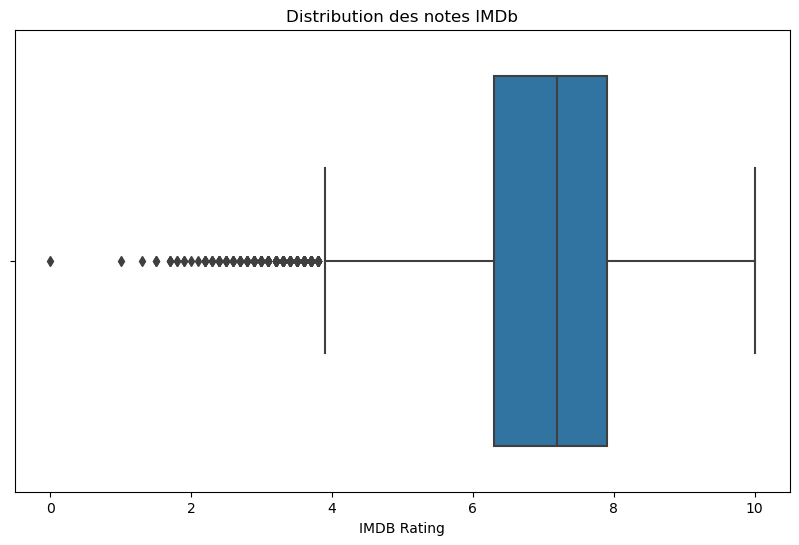

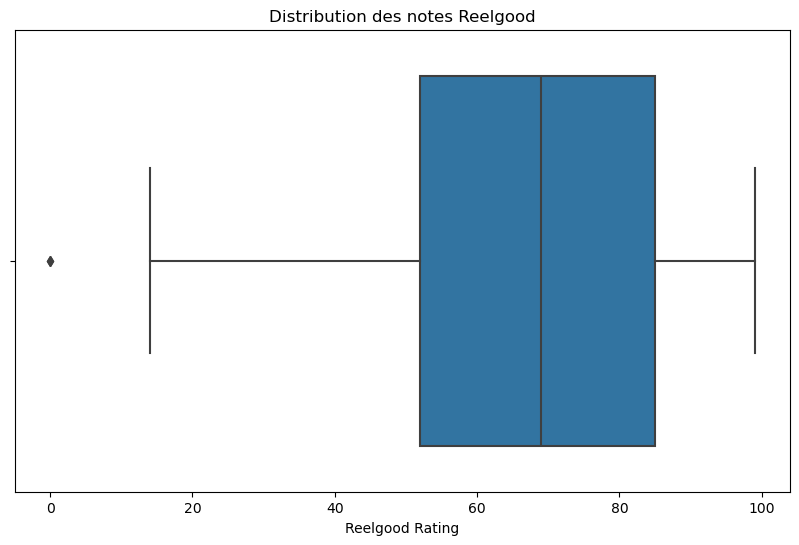

In [22]:
import seaborn as sns 
# Créer un diagramme en boîte à moustaches pour les notes IMDb
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['IMDB Rating'])
plt.title('Distribution des notes IMDb')
plt.show()

# Créer un diagramme en boîte à moustaches pour les notes Reelgood
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['Reelgood Rating'])
plt.title('Distribution des notes Reelgood')
plt.show()
